In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.datasets import tuple_dataset
from chainer import training
from chainer.training import extensions

c:\users\arata\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
chainer.print_runtime_info()

Platform: Windows-10-10.0.17134-SP0
Chainer: 5.4.0
NumPy: 1.16.2
CuPy:
  CuPy Version          : 5.4.0
  CUDA Root             : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.0
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7500
  cuDNN Version         : 7500
  NCCL Build Version    : None
  NCCL Runtime Version  : None
iDeep: Not Available


In [3]:
train, test = datasets.get_mnist(ndim=3)

この画像データのラベルは5です。


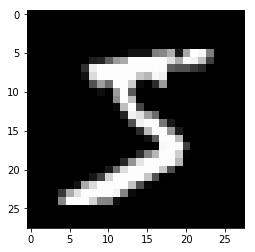

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

#mnist = 1 * 28 * 28 が 60000枚
plt.imshow(np.array(train[0][0][0], dtype=np.float32), cmap='gray')
print('この画像データのラベルは{:0d}です。'.format(train[0][1]))

In [16]:
class CNN(Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope(): 
            self.cn1 = L.Convolution2D(1, 20, 5) #width=(28-5)/1+1=24
            self.cn2 = L.Convolution2D(20, 50, 5) #width=(12-5)/1+1=8
            self.fc1 = L.Linear(800, 500) #width=4*4*50=800
            self.fc2 = L.Linear(500, 10)
    
    def __call__(self, x):
        h1 = F.max_pooling_2d(F.relu(self.cn1(x)), 2) #width=(24-2)/2+1=12
        h2 = F.max_pooling_2d(F.relu(self.cn2(h1)), 2) #width=(8-2)/2+1=4
        h3 = F.dropout(F.relu(self.fc1(h2)))
        return self.fc2(h3)

In [17]:
gpu_device = 0
epoch = 30
batch_size = 512
frequency = -1

In [18]:
model = L.Classifier(CNN())
chainer.cuda.get_device_from_id(0)
model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_device)
trainer = training.Trainer(updater, (epoch, 'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model,device=gpu_device))
trainer.extend(extensions.dump_graph('main/loss'))

frequency = epoch if frequency == -1 else max(1, frequency)
trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.357398    0.0768819             0.889119       0.976419                  6.28919       
2           0.0869545   0.0449386             0.974225       0.98592                   8.01685       
3           0.0599894   0.0354398             0.981504       0.989108                  9.74282       
4           0.0462942   0.0304483             0.985644       0.989987                  11.5027       
5           0.0389738   0.0291048             0.987647       0.990378                  13.2548       
6           0.0314853   0.0256366             0.990135       0.992004                  15.1611       
7           0.0278131   0.0255583             0.990869       0.99105                   16.8963       
8           0.0260903   0.0280496             0.991303       0.990659                  18.6488       
9           0.0218233   0.024263              0.992889       0.992406               

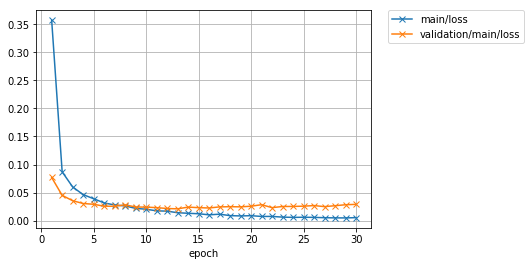

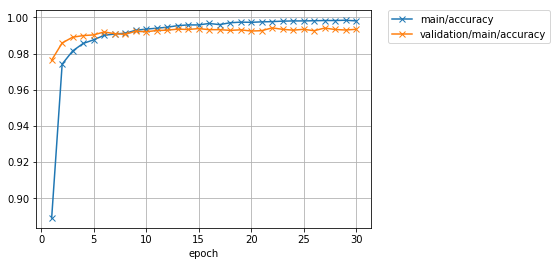

In [25]:
from IPython.display import Image, display_png

display_png(Image('result/loss.png'))
display_png(Image('result/accuracy.png'))

この画像データのラベルは7です。
[0.00000000000000124131 0.00000000000014495166 0.00000000000235763275
 0.00000000000698993294 0.00000000000403651418 0.00000000000000065800
 0.00000000000000000001 1.00000000000000000000 0.00000000000000000721
 0.00000000000070610022]


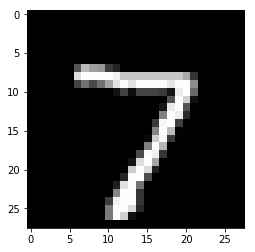

In [26]:
import cupy as cp

plt.imshow(np.array(test[0][0][0], dtype=np.float32), cmap='gray')
print('この画像データのラベルは{:0d}です。'.format(test[0][1]))

prediction = model.predictor(cp.array(test[0][0][0]).reshape(1, 1, 28, 28))
probability = chainer.cuda.to_cpu(F.softmax(prediction).data[0])
np.set_printoptions(precision=20, floatmode='fixed', suppress=True)
print(probability)